<a href="https://colab.research.google.com/github/alouwyck/maxsypy/blob/main/seminaries/UM6P_jan_2025/Day2/Part_3_Introduction_to_Deep_Learning_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

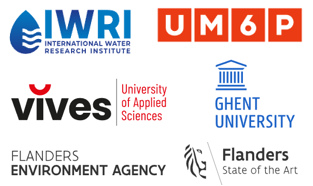<br>


**Mathematical Models and Artificial Intelligence**<br>
**for Solving Groundwater Flow Problems**<br>
Workshop organized by the<br>
International Water Research Institute (IWRI)<br>
University Mohammed VI Polytechnic<br>
January 6-7, 2025<br>
Dr. Andy Louwyck

---



<font size="6"><strong>DAY 2 - Artificial Intelligence</strong></font>

---
---

# **Part 3 - Introduction to Deep Learning with Python**

This notebook is a brief introduction to deep learning with Python. We'll make use of Keras, a popular deep learning library, which has become the high-level API of Google's TensorFlow, and allows us to easily build, train, and evaluate **artificial neural networks**. We also provide an example of how to use PyTorch, which is Meta's deep learning library.

Neural networks are inspired by biological brains. They also consist of **neurons** connected to each other, and exchanging signals with each other. The neurons in biological brains amplify or attenuate those signals. In an artificial neural network, the signals are the features, which are also amplified or attenuated by the neurons. In each neuron the weighted sum of the input is transformed by an **activation function**. The weights used in the weighted sum are the **parameters** of the model, which is an artificial neural network in this case.

A classical neural network consists of several layers, of which the input layer receives the features of the data, and passes them on to the internal hidden layers, which transform the features, finally arriving at the output layer, which makes the predictions. This is called the **forward pass**.

During training of the neural net, the model parameters are adjusted iteratively in order to minimize the **loss function**. Recall that the loss function is a measure of the difference between predicted and true labels or targets. In this step, two algorithms are involved: the **backpropagation** algorithm which adjusts the parameters, and an **optimizer** that minimizes the loss function.

## **0. Import Statements**

We need the following libraries:
- [NumPy](https://numpy.org/): library for numerical computation.
- [Pandas](https://pandas.pydata.org/): library for analyzing structured data
- [Matplotlib](https://matplotlib.org/): library for visualizing data
- [Scikit-Learn](https://scikit-learn.org/stable/): machine learning library
- [TensorFlow](https://www.tensorflow.org/) + [Keras](https://keras.io/): deep learning library
- [PyTorch](https://pytorch.org/): another deep learning library

We import these libraries using the `import` command. It is customary to give NumPy alias `np`, Pandas alias `pd`, and TensorFlow alias `tf`. From Matplotlib, we need the `pyplot` module; the convention is to import it as `plt`. From Scikit-Learn, Keras, and PyTorch, we import the classes we use at the time we need them.

In [1]:
import numpy as np  # numeric python
import pandas as pd  # python data analysis library
import matplotlib.pyplot as plt  # python library for visualizations
import tensorflow as tf  # Google's deep learning library
from tensorflow import keras  # Keras is TensorFlow's high-level API
import torch # Meta's deep learning library PyTorch

We also clone the [MAxSyPy](https://github.com/alouwyck/maxsypy) package from GitHub for simulating axisymmetric groundwater flow:

In [2]:
import os, shutil

# remove directory 'maxsypy' first if it already exists
path = "maxsypy"
if os.path.exists(path):
    shutil.rmtree(path)

# clone maxsypy repository from Github
!git clone https://github.com/alouwyck/maxsypy

# copy data files to current working directory
data_folder = './data'
if os.path.exists(data_folder):
    shutil.rmtree(data_folder)
shutil.copytree("./maxsypy/seminaries/UM6P_jan_2025/data", data_folder)

# put maxsypy package directory in the current working directory
os.rename(path, 'temp')
shutil.copytree(os.path.join('temp', path), path);
shutil.rmtree('temp')

Cloning into 'maxsypy'...
remote: Enumerating objects: 366, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 366 (delta 55), reused 5 (delta 5), pack-reused 233 (from 2)
Receiving objects: 100% (366/366), 22.27 MiB | 9.14 MiB/s, done.
Resolving deltas: 100% (162/162), done.


The MAxSyPy package implements several analytical and semi-analytical solutions discussed in my PhD thesis (Louwyck, 2023). We will use it to generate datasets.

## **1. Linear regression**

In the previous notebook on "Machine Learning with Python", we introduced simple linear regression and demonstrated how to train linear regression models using Scikit-Learn. What we didn't mention in that discussion is that the algorithm employed by Scikit-Learn provides an *exact solution*. This is possible because simple linear regression is a linear problem that can be solved *analytically*. The specific algorithm used is known as the **Ordinary Least Squares** method (OLS), and in the case of simple linear regression, it determines the exact minimum of the **loss function**, which is the sum of squared differences between predicted and actual target values. Consequently, the **parameters** derived from this algorithm are exact.

In deep learning, the neural nets are trained using an iterative **optimizer** that minimizes the loss function *numerically* yielding an *approximate solution* which is hopefully close enough to the exact solution. Why don't we solve deep learning problems analytically to get an exact solution? Well, most of these problems are nonlinear and too complex to find the analytical exact solution, so there is no other option than to apply an iterative numerical solution method. In deep learning, this method is called **stochastic gradient descent** and the optimizers that are used to minimize the loss function and find the optimal parameters implement variants to that algorithm.

Simple linear regression may also be performed using a neural network, in which case we get the simplest neural net possible containing *one node or neuron only*! In this case, however, the derived parameters will be approximations to the exact solution, as the optimizer is numerical and iterative.

### Creating the dataset

Let's give an example by fitting drawdowns generated using the Theis solution for transient flow to a pumping well that fully penetrates a confined aquifer:

In [3]:
from maxsypy.special import theis

t_obs = np.logspace(-3, 1, 100)  # observervation times (d)
r_obs = 0.1  # radial distance (m)
T = 10       # aquifer transmissivity (m²/d)
S = 0.001    # aquifer storativity (-)
Q = 500      # pumping rate (m³/d)

s_obs = theis(r=r_obs, t=t_obs, T=T, S=S, Q=Q).squeeze()  # drawdowns (m)

np.random.seed(0)
s_obs += np.random.randn(len(t_obs)) * 0.1  # add random error (m) to drawdowns

Plotting the generated data:

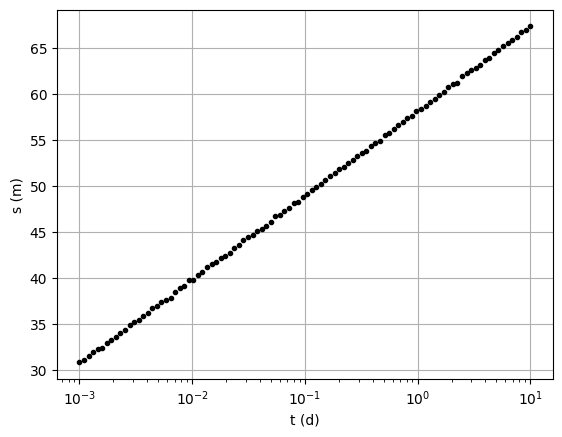

In [4]:
plt.semilogx(t_obs, s_obs, 'k.');
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.grid();

### Scikit-Learn

As before, we try to predict the drawdown from the observation time. So the first is the independent variable or feature `X`, while the latter is the dependent variable or target `y`. As usual, feature `X` is log-transformed:

In [5]:
X = np.log10(t_obs.reshape(-1, 1))
y = s_obs.reshape(-1, 1)

The `reshape` method is applied to convert the 1D vectors into 2D column matrices.

Recall that applying simple linear regression using Scikit-Learn is very straightforward, giving an exact solution for parameters `a` and `b`, which correspond to the slope and intercept of the fitted straight line:

In [6]:
from sklearn.linear_model import LinearRegression

exact = LinearRegression()
exact.fit(X, y)
a, b = exact.coef_[0][0], exact.intercept_[0]
a, b

(9.154131282266675, 58.187920817132984)

Let's calculate the MSE and R²:

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

yp = exact.predict(X)
print("MSE is", mean_squared_error(y_true=y, y_pred=yp))
print("R² is", r2_score(y_true=y, y_pred=yp))

MSE is 0.010093112995589917
R² is 0.9999114624513384


As expected, the coefficient of determination R² indicates an almost perfect fit, and the mean squared error MSE approximates the variance of the error we added to the simulated drawdowns.

We know from the previous notebook that we can apply the **Cooper-Jacob method** to derive the values for aquifer parameters T and S from the linear regression parameters:

In [8]:
def cooper_jacob(model):
    '''
    model: a fitted LinearRegression model
    '''
    ds = model.coef_.item()        # derived slope
    b  = model.intercept_.item()  # derived intercept
    t0 = 10 ** (-b / ds)                          # the intercept of the line on the x axis
    T_fitted = np.log(10.0) * Q / 4 / np.pi / ds  # derived value for T
    S_fitted = 4 / np.exp(np.euler_gamma) * T_fitted * t0 / r_obs**2  # derived value for S
    return T_fitted, S_fitted

T_fitted, S_fitted = cooper_jacob(exact)
print(f'Derived T = {T_fitted:.2f} m²/d')
print(f'Derived S = {S_fitted:.4f}')

Derived T = 10.01 m²/d
Derived S = 0.0010


### Keras

The easiest way to build a neural network that consists of one neuron only, is using the Keras class `Sequential` and add a `Dense` layer to it that contains one unit:

In [9]:
model = keras.Sequential()  # instantiate Sequential
model.add(keras.layers.Dense(units=1))  # add 1 layer with 1 unit or node

Before training this model, we need to `compile` it so Keras knowns which `loss` function it has to minimize and which `optimizer` it must use. Here we will minimize the Mean Squared Error (MSE) and we will apply the classical Stochastic Gradient Descent (SGD):

In [10]:
model.compile(loss="mse",       # MSE
              optimizer="sgd")  # SGD

Now we are ready to train the model by calling method `fit`. Just like with Scikit-Learn, we need to pass features `X` and target `y`. Additionally, the number of iterations must be passed as the solution method is iterative. Here, these iterations are called `epochs`, where one **epoch** refers to a single complete pass through the entire training dataset during the training process. Let's start with 15 epochs:

In [11]:
result = model.fit(X, y,
                   epochs=15);

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 2328.4204
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1992.6652  
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1571.5000  
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1362.4457  
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1225.1479  
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1071.1794  
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 930.7233
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 825.6363  
Epoch 9/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 772.9104 
Epoch 10/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 715.3112 
Epoch 11/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 690.3678 
Epoch 12/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 625.3335 
Epoch 13/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 539.8717 
Epoch 14/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 528.4025 
Epoch 15/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4

The loss is still very large after 15 epochs, so we'll continue the training for another 250 epochs:

In [12]:
result = model.fit(X, y,
                   epochs=250,  # we need a lot of epochs to reach the minimum
                   verbose=0);  # suppress output

Let's plot the loss function versus the number of epochs:

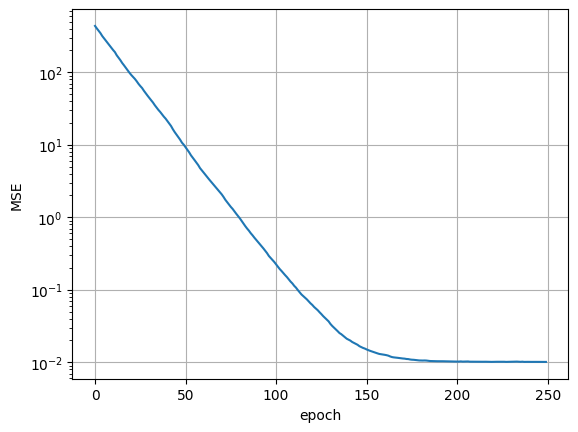

In [13]:
plt.semilogy(result.history['loss']);
plt.grid();
plt.xlabel('epoch');
plt.ylabel('MSE');

We see the loss function reaches a minimum after about 200 epochs of training. Let's check the parameters, which are called `weights` here:

In [14]:
a2, b2 = tuple(model.layers[0].weights)
a2 = a2.numpy().squeeze().item()
b2 = b2.numpy().squeeze().item()
a2, b2

(9.151921272277832, 58.18277359008789)

To compare the results, we may calculate the MSE and the R² score, for which we need to `predict` the target:

In [15]:
y_pred = model.predict(X)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


We get scores that are very close to the scores calculated previously for the Scikit-Learn model:

In [16]:
print("MSE is", mean_squared_error(y_true=y, y_pred=y_pred))
print("R² is", r2_score(y_true=y, y_pred=y_pred))

MSE is 0.010108406706808707
R² is 0.9999113282937497


Let's plot the result:

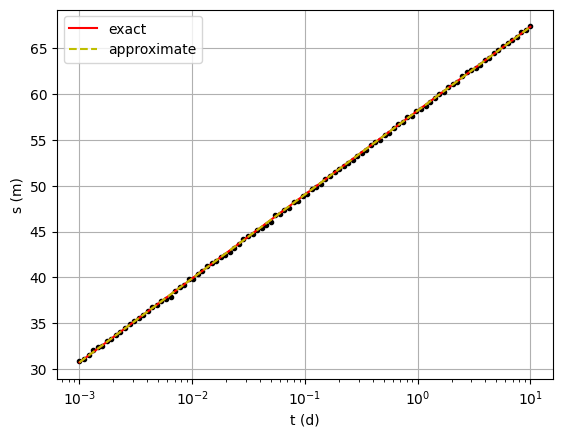

In [17]:
# scatter plot
plt.semilogx(t_obs, s_obs, 'k.');
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.grid();

# exact regression line
xline = np.array([-3, 1], dtype=float)
yline = a * xline + b
plt.semilogx(10**xline, yline, 'r-', label='exact');

# approximate regression line
xline = np.array([-3, 1], dtype=float)
yline = a2 * xline + b2
plt.semilogx(10**xline, yline, 'y--', label='approximate');  # don't forget to scale back!
plt.legend();

Instead of using the weights to draw the regression line, it is also possible here to "predict" this line:

```python
yline = model.predict(xline)
```

We see that the exact solution returned by the Scikit-Learn code and the approximate solution given by the Keras model are virtually the same!

## **2. Gradient Descent**

Before we present other examples of deep learning, let's first take a moment to discuss the gradient descent algorithm. It is a fundamental optimization algorithm used to minimize the loss function in machine learning models, including artificial neural networks. It works by iteratively adjusting the model's parameters in the direction that reduces the loss, thereby improving the model's performance.

In deep learning, gradient descent is often applied in a stochastic manner, known as stochastic gradient descent (SGD). Unlike traditional gradient descent, which uses the entire dataset to compute the gradient, SGD updates the model parameters using only one sample, or a small, randomly selected subset of the data (a mini-batch) at each iteration. This approach introduces randomness, which helps in escaping local minima and speeding up the convergence process.

### A curve-fitting problem

To illustrate how gradient descent works, we will provide a simple example where Theis curves are fitted to generated pumping test data:

In [18]:
from maxsypy.special import theis

t_obs = np.logspace(-3, 1, 100)  # observervation times (d)
r_obs = np.array([1, 10])        # radial distance (m)

T = 500   # aquifer transmissivity (m²/d)
S = 0.1   # aquifer storativity (-)
Q = 1000  # pumping rate (m³/d)

s_obs = theis(r=r_obs, t=t_obs, T=T, S=S, Q=Q)  # observed drawdowns (m)

np.random.seed(0)
s_obs += np.random.randn(len(r_obs), len(t_obs)) * 0.01  # add random error
s_obs[s_obs < 0] = 0.0  # set negative values to zero

Visualizing the generated dataset:

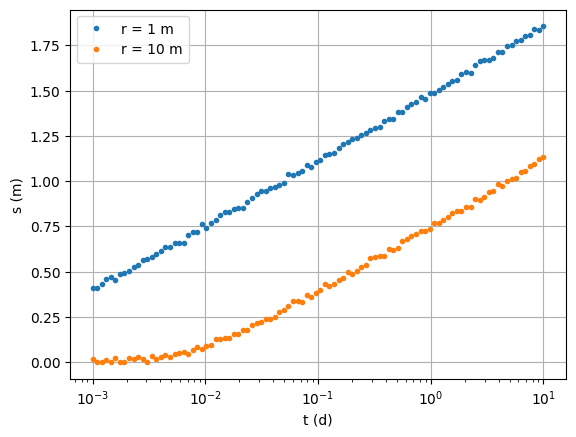

In [19]:
plt.semilogx(t_obs, s_obs.T, '.');
plt.legend([f'r = {r} m' for r in r_obs]);
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.grid();

### The Gradient Descent algorithm

To easily visualize how the optimization problem is solved, we will derive only one value for parameter T.

The principle is simple: we start with an arbitrary value for T (whose actual value we wouldn't know in reality), simulate the drawdowns for the given distances and times using the function `theis`, and compare them with the observed drawdowns from our dataset. We do this comparison using a loss function, in this case, the mean squared error, or MSE for short. The goal is to find the minimum value for the MSE, as this means that, on average, the simulated and observed drawdowns are closest to each other.

How do we find that minimum? Well, we calculate the gradient at the point corresponding to the initially chosen value for T, and since this gradient indicates the slope of the loss function at that point, we can use it to take a step 'downhill' towards the minimum. We repeat this until we have taken enough steps to get close enough to the minimum of the loss function.

Let's plot the MSE as a function of a range of values for parameter T:

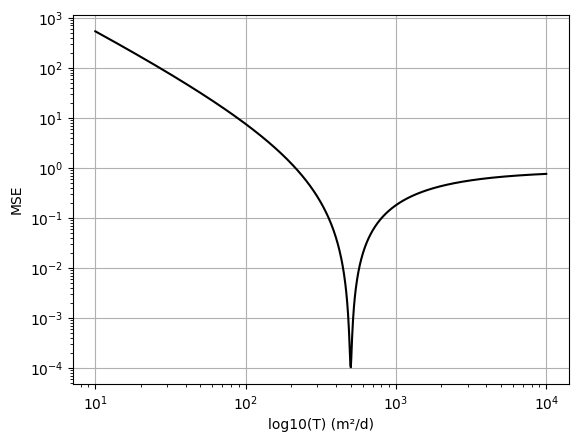

In [20]:
from sklearn.metrics import mean_squared_error

# calculate MSE as a function of T
T_range = np.logspace(1, 4, 1000);  # range of T values
MSEs = []
for i in range(len(T_range)):  # loop over the T values
    s_sim = theis(r=r_obs, t=t_obs, T=T_range[i], S=S, Q=Q)  # simulate drawdowns using theis
    mse = mean_squared_error(s_obs, s_sim)  # calculate MSE between simulated and observed drawdowns
    MSEs.append(mse)

# plot MSE as a function of T
plt.loglog(T_range, MSEs, 'k-');
plt.xlabel('log10(T) (m²/d)');
plt.ylabel('MSE');
plt.grid();

As expected, the minimum of the MSE is indeed around T = 500 m²/d. In reality, we do not know this value, so we start with a random value for T. The Gradient Descent algorithm iteratively adjusts T to minimize the difference between the observed and simulated drawdowns, aiming to find the optimal value for T.

The following code is designed to optimize parameter T using gradient descent to minimize the MSE between observed and simulated drawdowns. Here's a step-by-step explanation:

**Initial Setup:**

- `log10_T` is initialized as a TensorFlow variable with a value of 1.0, representing the logarithm of the initial guess for T. So, the initial guess for T is 10 m²/d.
- `alpha` is the learning rate, set to 0.0001. It's a hyperparameter that controls how much parameter T is adjusted during each step of the optimization process.
- `epochs` is the number of iterations for the training loop, set to 10,000.
- `result` is a dictionary to store the values of T and MSE at each 1000th epoch.

**Training Loop:**

- For each epoch, the code calculates the current value of T from `log10_T`.
- It then simulates the drawdowns `s_sim` using the `theis` function with the current T value and other known variables (`r_obs`, `t_obs`, `S`, `Q`).
- The MSE between the observed drawdowns `s_obs` and the simulated drawdowns `s_sim` is calculated.
- The gradient of the MSE with respect to `log10_T` is determined using TensorFlow's automatic differentiation.
- `log10_T` is updated by moving in the direction of the negative gradient, scaled by the learning rate `alpha`. The negative gradient is taken because it must go downhill!

**Logging and Saving Results:**

- Every 1000 epochs, the current MSE and T are printed and saved in the `result` dictionary.

**Post-Training:**

- After the training loop, the final optimized value of T is calculated.
- The final simulated drawdowns are computed using the optimized T.
- The final MSE is calculated and printed.
- The results are plotted, showing the observed and simulated drawdowns on a semi-logarithmic plot.

Epoch 0: MSE = 533.23681640625, T = 10.0
Epoch 1000: MSE = 0.05747697874903679, T = 383.8609313964844
Epoch 2000: MSE = 0.006918391212821007, T = 453.3651428222656
Epoch 3000: MSE = 0.0012387786991894245, T = 479.92889404296875
Epoch 4000: MSE = 0.00031432698597200215, T = 491.1391296386719
Epoch 5000: MSE = 0.00014375006139744073, T = 496.0382385253906
Epoch 6000: MSE = 0.00011058770178351551, T = 498.2070617675781
Epoch 7000: MSE = 0.00010393155389465392, T = 499.174560546875
Epoch 8000: MSE = 0.00010259589180350304, T = 499.5890808105469
Epoch 9000: MSE = 0.00010226716403849423, T = 499.79644775390625
Epoch 9999: MSE = 0.00010226719485992922, T = 499.79644775390625


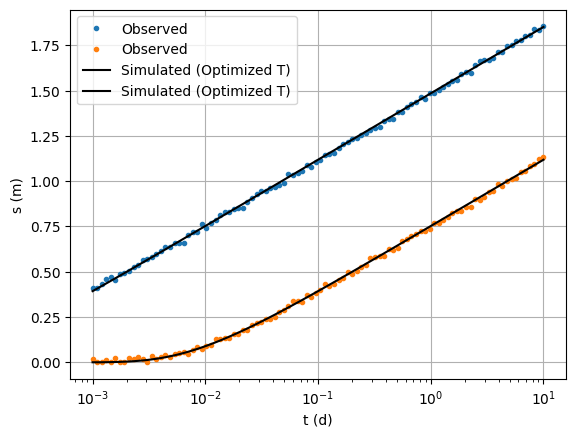

In [21]:
# prompt: Use tensorflow and apply grandient descent to minimize MSE between s_obs and s simulated
# using function theis. Only optimize parameter log10(T).

# Initial guess for log10(T)
log10_T = tf.Variable(1.0, dtype=tf.float32)

# Learning rate
alpha = 0.0001

# Training loop
epochs = 10000
result = {'T': [], 'MSE': []}
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Calculate T from log10_T
        T_opt = tf.pow(10.0, log10_T)
        s_sim = theis(r=tf.constant(r_obs, dtype=tf.float32),
                      t=tf.constant(t_obs, dtype=tf.float32),
                      S=tf.constant(S, dtype=tf.float32),
                      Q=tf.constant(Q, dtype=tf.float32),
                      T=T_opt)
        # Calculate Mean Squared Error
        mse = tf.reduce_mean(tf.square(s_obs - s_sim))

    # Determine gradient
    gradient = tape.gradient(mse, log10_T)

    # Use gradient and learning rate to modify log10_T
    log10_T.assign_add(alpha * -gradient)

    # Print and save result each 1000 epochs
    if epoch % 1000 == 0:
        mse, T_opt = mse.numpy(), T_opt.numpy()
        print(f"Epoch {epoch}: MSE = {mse}, T = {T_opt}")
        result['T'].append(T_opt)
        result['MSE'].append(mse)

# After training
T_opt = tf.pow(10.0, log10_T).numpy()
s_sim = theis(r=r_obs, t=t_obs, T=T_opt, S=S, Q=Q);
mse = tf.reduce_mean(tf.square(s_obs - s_sim)).numpy()
print(f"Epoch {epoch}: MSE = {mse}, T = {T_opt}")
result['T'].append(T_opt)
result['MSE'].append(mse)

# Plot the results
s_sim_final = theis(r=r_obs, t=t_obs, T=T_opt, S=S, Q=Q);
plt.semilogx(t_obs, s_obs.T, '.', label='Observed');
plt.semilogx(t_obs, s_sim_final.T, 'k-', label='Simulated (Optimized T)');
plt.legend();
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.grid();

Let's visualize the optimization process using a Matplotlib animation:

In [22]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

def init():
    ax1.semilogx(t_obs, s_obs.T, '.');
    ax1.legend([f'r = {r} m' for r in r_obs]);
    ax1.set_xlabel('t (d)');
    ax1.set_ylabel('s (m)');
    ax1.set_xlim(ax1.get_xlim());
    ax1.set_ylim(ax1.get_ylim());
    ax1.grid();

    ax2.loglog(T_range, MSEs, 'k-');
    ax2.set_xlabel('T (m²/d)');
    ax2.set_ylabel('MSE (m²)');
    ax2.set_xlim(ax2.get_xlim());
    ax2.set_ylim(ax2.get_ylim());
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.grid();

def update(i):
    for line in ax1.get_lines():
        if line.get_linestyle() == '-': line.remove()
    mse, T_opt = result['MSE'][i], result['T'][i]
    s_sim = theis(r=r_obs, t=t_obs, T=T_opt, S=S, Q=Q)
    lines = ax1.semilogx(t_obs, s_sim.T, 'k-');
    ax2.semilogx(T_opt, mse, 'r.');

anim = FuncAnimation(fig, update, frames=range(len(result['MSE'])), init_func=init, blit=False)
plt.close()
anim

## **3. Logistic regression**

In the previous notebook on "Machine Learning with Python", we also introduced logistic regression and demonstrated how to train logistic regression models using Scikit-Learn. Just like linear regression, it is also possible to build a neural network that does the same. Again, a very simple neural net consisting of one neuron only can do the job. In this case, however, an additional transformation is required to convert the weighted sum of the input features into a probability between 0 and 1. This is achieved by applying an **activation function**, which is the **sigmoid** function in this case:

> $y = \sigma(x)= \dfrac{1}{1+e^{-x}}$

Using NumPy and Matplotlib, it is easy to implement this function and plot it:

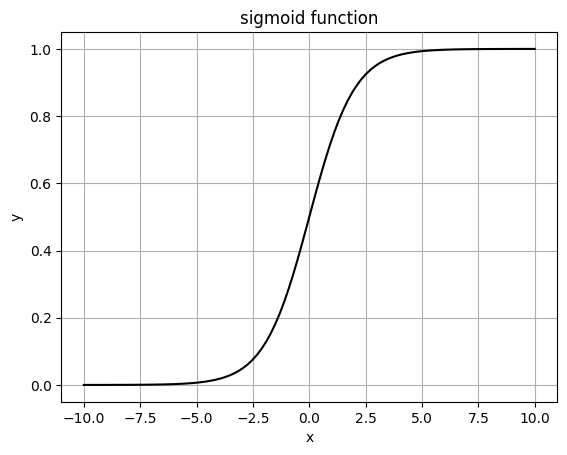

In [23]:
x = np.linspace(-10, 10, 100)  # create array of 100 evenly spaced points between -10 and 10
sigmoid = lambda x: 1 / (1 + np.exp(-x))

plt.plot(x, sigmoid(x), 'k-');
plt.grid();
plt.title('sigmoid function');
plt.xlabel('x');
plt.ylabel('y');

We see indeed that argument $x$ is transformed into a number $y$ between 0 and 1. If $x = 0$, then the sigmoid function returns 0.5, which corresponds to a probability of 50%. Positive values are mapped to a number greater than 0.5, while negative values to a number less than 0.5. Mathematically, the function returns 1 if $x$ is $\infty$, and it returns 0 if $x$ is $-\infty$. From the graph, it is clear that $x$ values greater than 5 are mapped to a value very close to 1, and values smaller than -5 to a value very close to 0:

In [24]:
sigmoid(np.array([-5, 5]))

array([0.00669285, 0.99330715])

What about the optimization algorithm? For logistic regression, Scikit-Learn also uses an iterative optimizer by default, but as is the case for linear regression, it is a much more efficient one for solving this particular kind of linear and binary classification problems. Let's find out!

### Creating the dataset

We create a dataset of 1000 random samples with two features: radial distances `r` and observation times `t`. Each sample has a label `steady` indicating whether the flow at that point in space and time is steady (`True`) or transient (`False`). To keep things simple, we assign the label `True` to data points with time `t` greater than 10:

In [25]:
np.random.seed(0)
r = []
t = []
steady = []
for _ in range(1000):
    r.append(10 ** (np.random.rand(1) * 2 - 1))
    t.append(10 ** (np.random.rand(1) * 6 - 2))
    steady.append(t[-1] > 10)
r = np.array(r)
t = np.array(t)
steady = np.array(steady)

We mislabel some data points to avoid the logistic regression model from achieving a 100% accuracy score:

In [26]:
# prompt: Replace randomly 20% of the data points in 'steady' by inverting their boolean value.
# Select data points between 5 <= t <= 50

# Select indices of data points where 5 <= t <= 50
indices_to_modify = np.where((t >= 5) & (t <= 50))[0]

# Calculate the number of data points to modify (20% of selected points)
num_to_modify = int(0.2 * len(indices_to_modify))

# Randomly select indices within the specified range
np.random.seed(0)
random_indices = np.random.choice(indices_to_modify, size=num_to_modify, replace=False)

# Invert the boolean values of the selected data points
steady[random_indices] = ~steady[random_indices]

Let's create matrix `X` with the two features `log10(r)` and `log10(t)`, and vector `y` with the labels `steady`:

In [27]:
X = np.log10(np.c_[r, t])
y = steady.astype(int).flatten()

### Scikit-Learn

First, we apply logistic regression by using Scikit-Learn class `LogisticRegression`:

In [28]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty=None)
lr.fit(X, y)
lr.score(X, y)

0.963

The model's **accuracy** is 96.3%.

### Keras

Now, let's build and train a neural network for logistic regression using Keras. We define one layer having one unit only and `'sigmoid'` as `activation` function:

In [29]:
model = keras.Sequential()
model.add(keras.layers.Dense(units=1,  # one node only
                             activation='sigmoid'))  # sigmoid as activation function

Compiling the model. This time, the `loss` function is binary cross entropy or log loss, which is a very efficient loss function for binary classification problems. But as it is difficult to interpret this loss function, we also define `'accuracy'` as metric:

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=['accuracy'])

Training the model. As you see, we need a lot of epochs here. Therefore, we group the data points into **batches**, which are created randomly during training. The `batch_size` determines the number of samples in each batch. By default, the optimizer processes one sample at a time.

In [31]:
result = model.fit(X, y,
                   epochs=500,
                   batch_size=64,
                   verbose=0)  # no output

Let's plot the loss and the accuracy during training:

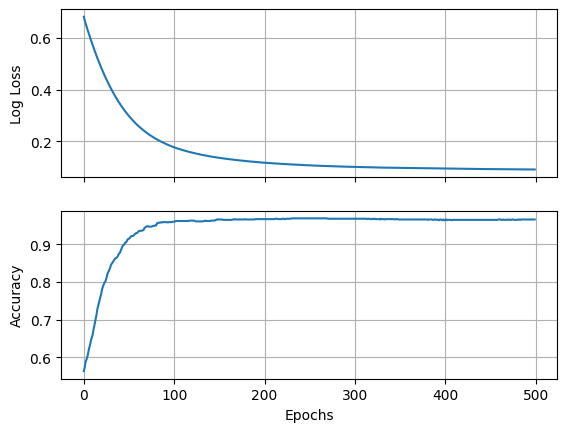

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(result.history['loss']);
ax1.grid();
ax1.set_ylabel('Log Loss');

ax2.plot(result.history['accuracy']);
ax2.grid();
ax2.set_ylabel('Accuracy');
ax2.set_xlabel('Epochs');

The model converges to the minimum of the loss function. By calling method `evaluate`, we get the final loss and accuracy:

In [33]:
loss, acc = tuple(model.evaluate(X, y, verbose=0))
print('Log Loss:', loss)
print('Accuracy:', acc)

Log Loss: 0.09030886739492416
Accuracy: 0.9660000205039978


The neural net performs slightly better than Scikit-Learn's logistic regression model! Let's visualize the separating lines that both models found:

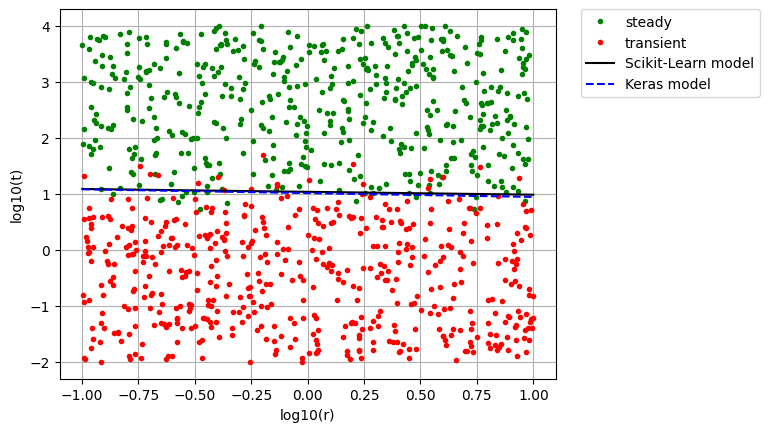

In [34]:
log_r_line = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
w, b = lr.coef_[0], lr.intercept_[0]
log_t_line = -(log_r_line * w[0] + b) / w[1]
w2, b2 = model.layers[0].weights[0].numpy().flatten(), model.layers[0].weights[1].numpy()
log_t_line2 = -(log_r_line * w2[0] + b2) / w2[1]

plt.plot(X[steady.flatten(), 0], X[steady.flatten(), 1], 'g.', label='steady');
plt.plot(X[~steady.flatten(), 0], X[~steady.flatten(), 1], 'r.', label='transient');
plt.plot(log_r_line, log_t_line, 'k-', label='Scikit-Learn model');
plt.plot(log_r_line, log_t_line2, 'b--', label='Keras model');
plt.xlabel('log10(r)');
plt.ylabel('log10(t)');
plt.grid();
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

The separating lines determined by both models are very close, but do not coincide. This explains the slightly different accuracy scores.

### PyTorch

We can build a simular model using PyTorch:

In [35]:
# Define the neural network
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

# Prepare the data
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32).unsqueeze(1) # Add unsqueeze for single output

# Initialize the model, loss function, and optimizer
input_dim = X_torch.shape[1]
model = LogisticRegressionModel(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # learning rate

# Train the model
num_epochs = 5000
losses = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_torch)
    loss = criterion(outputs, y_torch)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save and print loss
    losses.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/5000], Loss: 0.5216
Epoch [200/5000], Loss: 0.4125
Epoch [300/5000], Loss: 0.3565
Epoch [400/5000], Loss: 0.3199
Epoch [500/5000], Loss: 0.2932
Epoch [600/5000], Loss: 0.2725
Epoch [700/5000], Loss: 0.2559
Epoch [800/5000], Loss: 0.2422
Epoch [900/5000], Loss: 0.2307
Epoch [1000/5000], Loss: 0.2208
Epoch [1100/5000], Loss: 0.2123
Epoch [1200/5000], Loss: 0.2048
Epoch [1300/5000], Loss: 0.1982
Epoch [1400/5000], Loss: 0.1924
Epoch [1500/5000], Loss: 0.1871
Epoch [1600/5000], Loss: 0.1824
Epoch [1700/5000], Loss: 0.1781
Epoch [1800/5000], Loss: 0.1742
Epoch [1900/5000], Loss: 0.1707
Epoch [2000/5000], Loss: 0.1674
Epoch [2100/5000], Loss: 0.1644
Epoch [2200/5000], Loss: 0.1616
Epoch [2300/5000], Loss: 0.1590
Epoch [2400/5000], Loss: 0.1565
Epoch [2500/5000], Loss: 0.1543
Epoch [2600/5000], Loss: 0.1522
Epoch [2700/5000], Loss: 0.1502
Epoch [2800/5000], Loss: 0.1483
Epoch [2900/5000], Loss: 0.1466
Epoch [3000/5000], Loss: 0.1449
Epoch [3100/5000], Loss: 0.1433
Epoch [3200/5000]

Evaluating the model:

In [36]:
with torch.no_grad():
    outputs = model(X_torch)
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_torch).sum().item() / len(y_torch)
    print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9680


Besides the fact that the PyTorch code is more low-level, there are some other small differences. As we did not use batches, convergence was very slow using Keras' default value for the **learning rate**. Therefore, we finally used a learning rate ten times larger, at 0.01, to speed up the learning process. This *hyperparameter* determines the size of the steps the optimizer takes, and by increasing it, the optimizer will take larger steps.

## **4. Text Classification**

Text classification plays a crucial role in various machine learning applications, one of which is **sentiment analysis**. It is a form of classification, where the goal is to determine the sentiment or emotional tone within a given piece of text. In this particular example, we are delving into a common use case: discerning whether a movie review expresses a positive or negative sentiment. As there are two classes, we are dealing here with **binary classification**.

This task falls under the umbrella of **Natural Language Processing** (NLP), a subfield of artificial intelligence that focuses on enabling machines to understand, interpret, and generate human language. NLP techniques are instrumental in tasks like sentiment analysis, enabling us to unlock valuable insights from the vast ocean of text data available on the web. Other NLP tasks are content filtering, translating text from one language into another, summarizing texts, converting speech to text, etc.

### Vectorization

As we are dealing with text data and neural nets are only capable of processing numerical data, we need to convert these text data into numerical data, a process that is called **vectorization**. The following steps are distinguished:
1. *standardization*: converting to lower case, removing punctuations, replacing special characters, etc.;
2. *tokenization*: splitting text into words or group of words;
3. *indexing*: converting words to integers;
4. *encoding*: transforming the integer vectors to input tensors for the neural net.

Let's illustrate this preprocessing step using a very simple example dataset consisting of two text documents only:

In [37]:
docs = ['The cat sat on the mat.',
        'When the cat is away, the mice will play!']
docs

['The cat sat on the mat.', 'When the cat is away, the mice will play!']

In the first step the two documents are standardized by converting the strings to lower case and by removing the punctuations. For the latter, we use a *regular expression*:

In [38]:
import re  # module for regular expressions

docs = [doc.lower() for doc in docs]  # lower case
docs = [re.sub(r'[^\w\s]', '', doc) for doc in docs]  # remove punctuations
docs

['the cat sat on the mat', 'when the cat is away the mice will play']

In the second step, the strings are tokenized by splitting them into words:

In [39]:
docs = [doc.split(" ") for doc in docs]
docs

[['the', 'cat', 'sat', 'on', 'the', 'mat'],
 ['when', 'the', 'cat', 'is', 'away', 'the', 'mice', 'will', 'play']]

To convert the words to indices, we first need the *vocabulary*, that is the set of unique words in the dataset. Each word in this set gets a unique index. For convenience, we define this vocabulary as a dictionary `{word=index}`:

In [40]:
unique_words = set([word for doc in docs for word in doc])
vocabulary = {word: id for id, word in enumerate(unique_words)}
vocabulary

{'on': 0,
 'mat': 1,
 'cat': 2,
 'away': 3,
 'the': 4,
 'when': 5,
 'will': 6,
 'sat': 7,
 'play': 8,
 'mice': 9,
 'is': 10}

Once we have the vocabulary, it is easy to convert the tokenized documents to integer vectors:

In [41]:
samples = [[vocabulary[word] for word in doc] for doc in docs]
samples

[[4, 2, 7, 0, 4, 1], [5, 4, 2, 10, 3, 4, 9, 6, 8]]

In the finale step, feature matrix `X` is created by applying **multi-hot encoding**. The features are the words in the vocabulary, so each column of `X` represents a word, while each row of `X` corresponds to a sample. If the word occurs in the sample, then the corresponding entry of `X` is `1`, otherwise it is `0`:

In [42]:
X = np.zeros((len(samples), len(vocabulary)), dtype=int)
for i, sample in enumerate(samples):
    X[i, sample] = 1
X

array([[1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1]])

To get a better idea how matrix `X` is constructed, we convert it to a Pandas DataFrame:

In [43]:
pd.DataFrame(columns=vocabulary.keys(), data=X)

,on,mat,cat,away,the,when,will,sat,play,mice,is
0,1,1,1,0,1,0,0,1,0,0,0
1,0,0,1,1,1,1,1,0,1,1,1


Matrix `X` is a binary vector in this case indicating whether or not a word occurs in a document. It is also possible to count the number of times a word occurs in a sample.

### The IMDB dataset

In this example, we'll use the IMDB dataset, sourced from the popular [movie database](https://www.imdb.com/). It comprises a collection of 50,000 movie reviews, and it is perfectly balanced, with 50% of the reviews expressing positive sentiment and the other 50% conveying negative sentiment. The dataset is divided into 25,000 training samples and 25,000 testing samples. It can be downloaded from the Keras datasets. Here, we restrict the dataset to the 10,000 most frequent words:

In [44]:
from keras.datasets import imdb

num_words = 10_000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


As usual, the dataset is divided into a training set and a test set, and there are data and corresponding labels. As classification is a kind of *supervised learning*, we need both.

The labels are easy to understand:
- `1` stands for a positive review;
- `0` for a negative review.

In [45]:
train_labels[0]  # label of the first review

1

 Each sample in the dataset corresponds to a review.The words have already been converted into integers during a preprocessing step called **vectorization**:

In [46]:
train_data[0][:10]  # the first 10 words from the first review

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

Recall that the *vocabulary* was limited to the 10,000 most frequent words. This can be easily verified by checking the maximum integer index of the samples:

In [47]:
print(max([max(review) for review in train_data]))
print(max([max(review) for review in test_data]))

9999
9999


As we start counting from 0, the maximum index should be 9999 indeed! But what words correspond to these indices? The dataset object has a method `get_word_index` which returns a dictionary that maps each word in the dataset to its index. Let's get the first 50 words of the first sample in the training set:

In [48]:
word_index = imdb.get_word_index()  # dict {word=index}
reverse_word_index = {index: value for value, index in word_index.items()} # we want dict {index=word}
" ".join([reverse_word_index[i] for i in train_data[0][:50]])  # first 50 words of first sample

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several'

We see the words don't make sense as the original sentences are not preserved! It is important to understand that the model we'll build and train doesn't take into account the **word order**! There are other neural network architectures, like *Long Short-Term Memory* (LSTM) models or the widely used and popular *Transformers*, that can better preserve and utilize word order.

The text data have already been converted to integer vectors. The problem here is that not all vectors have the same length, which is required for neural network inputs. We may apply *padding* by appending zeros to the vectors, but here, we will apply **multi-hot encoding**:

In [49]:
def multi_hot(data):
    x = np.zeros((len(data), num_words))
    for i, review in enumerate(data):
        x[i, review] = 1.
    return x

x_train = multi_hot(train_data)
x_test = multi_hot(test_data)

Finally, we convert the labels to single-precision floating point numbers:

In [50]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### The classification model

We build and train a similar model as in previous section on predicting house prices. However, as we are dealing with binary classification here, there are some important differences:

1. **Output Layer:** In binary classification, the output layer of the neural network typically applies *sigmoid* as an activation function, just like logistic regression does. This means that the output of the model is the probability that a sample is positive.

2. **Loss Function:** It is possible to use Mean Squared Error (MSE) as loss function, but a better choice is the *Binary Cross Entropy* or Log Loss, just like in logistic regression.

3. **Evaluation Metric:** *Accuracy* is a typical metric used for evaluating the performance of a classification model as it is easy to interpret. Additionally, a *confusion matrix* may be created and precision and recall may be derived from it.

The model itself consists of 3 layers:
- the first layer has 16 units and ReLU as activation function;
- the second layer has 16 units and also ReLU as activation function;
- as already explained the output layer has 1 unit and sigmoid as activation function.

In [51]:
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

In the compiling step we define the Binary Cross Entropy as loss function and RMSprop as optimizer to minimize it, while accuracy is defined as evaluation metric:

In [52]:
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

As in previous example, we'll apply **simple hold-out validation** to monitor the model's performance and detect the point where overfitting might occur. We'll use the last 10,000 samples of the training set for validating the model:

In [53]:
n = 10_000
x_val = x_train[:n]
partial_x_train = x_train[n:]
y_val = y_train[:n]
partial_y_train = y_train[n:]

We're ready now to train the model! We define 15 epochs and a batch size of 512:

In [54]:
result = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=15,
    batch_size=512,
    validation_data=(x_val, y_val)  # validation set
)

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.6693 - loss: 0.6145 - val_accuracy: 0.8518 - val_loss: 0.4052
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8889 - loss: 0.3382 - val_accuracy: 0.8783 - val_loss: 0.3204
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9200 - loss: 0.2431 - val_accuracy: 0.8891 - val_loss: 0.2820
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9361 - loss: 0.1945 - val_accuracy: 0.8875 - val_loss: 0.2793
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9520 - loss: 0.1551 - val_accuracy: 0.8863 - val_loss: 0.2831
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9557 - loss: 0.1351 - val_accuracy: 0.8711 - val_loss: 0.3289
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9634 - loss: 0.1182 - val_accuracy: 0.8796 - val_loss: 0.3067
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9733 - loss: 0.0961 - val_accuracy: 0.8804 - 

Let's plot training and validation loss and accuracy:

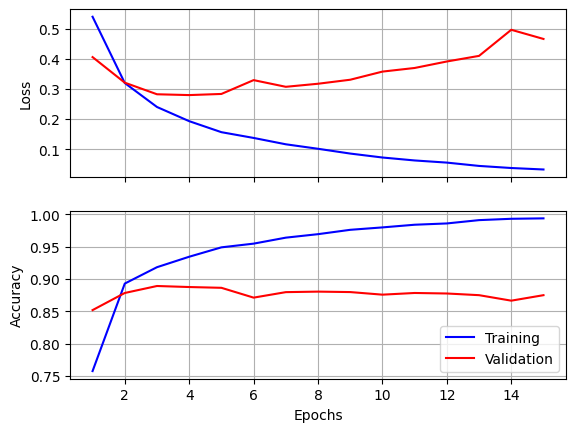

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

epochs = range(1, len(result.history['loss']) + 1)
ax1.plot(epochs, result.history['loss'], "b-", label="Training");
ax1.plot(epochs, result.history['val_loss'], "r-", label="Validation");
ax1.set_ylabel('Loss');
ax1.grid();

ax2.plot(epochs, result.history['accuracy'], "b-", label="Training");
ax2.plot(epochs, result.history['val_accuracy'], "r-", label="Validation");
ax2.set_xlabel('Epochs');
ax2.set_ylabel('Accuracy');
ax2.grid();
ax2.legend();

Looking at the loss graph, it is clear **overfitting** occurs already after 4 epochs! Therefore, we retrain the model for 4 epochs using the entire training set:

In [56]:
# build
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

# compile
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# fit
result = model.fit(
    x_train,   # full training set!
    y_train,
    epochs=4,  # 4 ipv 20!!
    batch_size=512,
)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7215 - loss: 0.5716
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8999 - loss: 0.3022
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9264 - loss: 0.2183
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9337 - loss: 0.1918


We `evaluate` this final model using the test set:

In [57]:
loss, acc = tuple(model.evaluate(x_test, y_test))
print('Log Loss:', loss)
print('Accuracy:', acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8792 - loss: 0.2977
Log Loss: 0.2978505790233612
Accuracy: 0.8801599740982056


We get an accuracy of 88%, which could be better. However, to obtain an accuracy of 95% or more, we would have to apply a state-of-the-art neural network...

If we want to plot a confusion matrix for the test data, then we first have to `predict` the labels:

In [58]:
prob = model.predict(x_test, verbose=0)
prob

array([[0.17483962],
       [0.99710685],
       [0.40610975],
       ...,
       [0.08354201],
       [0.05590601],
       [0.45023766]], dtype=float32)

Unlike Scikit-Learn, the `predict` method returns the calculated probabilities instead of the predicted labels. So we need to apply the `round` function to convert these probabilities to predictions:

In [59]:
yp = np.round(prob)
yp

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

Now it is easy to plot the confusion matrix using static method `from_predictions`:

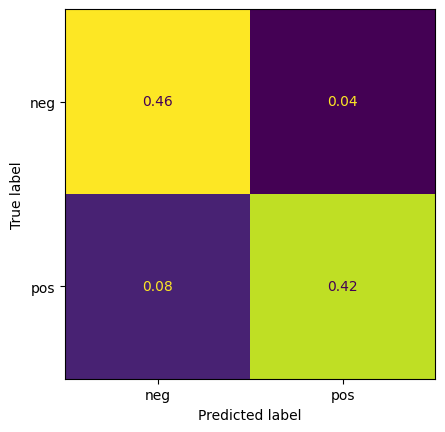

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=yp,
                                        normalize='all',
                                        display_labels=('neg', 'pos'),  # labels for 0 and 1
                                        colorbar=False);  # no colorbar

Because we have a lot of data, we have normalized the numbers so that the corresponding percentages are displayed.

## **5. Image Classification**

Neural networks are also very successful in **computer vision**. In particular, **convolutional networks** (CNNs or convnets) have proven to be very efficient in recognizing patterns in images. In this notebook, we will demonstrate this with a classic example of **image classification**: classifying the handwritten digits from the MNIST dataset.

First we will train a network with traditional dense layers on the dataset, after which we will try to improve the performance by using a network with convolutional layers. The neurons in such a layer do not calculate a weighted sum, but apply a mathematical operation called convolution. The same operation is also used, for example, to make photos blurrier or sharper. Think about applying filters in Instagram. Simply put, a convnet derives by itself the best filters from the given images, which allows for "recognizing" lines, colors, textures and objects. Based on that, it can classify the images.

Discussing the very technical details of convolutional neural networks is not within the scope of this workshop. Here, we just want to experience the power and efficiency of neural networks. The example of classifying handwritten digits that we discuss here could be regarded as the 'hello world' of deep learning for computer vision. So, prepare yourself and set your hardware accelerator to GPU! (In Google Colab you can do this in the "Edit > Notebook settings" menu).

###MNIST dataset

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) of handwritten digits is available with Keras and can be downloaded from `datasets.mnist`:

In [61]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We notice 2 things:

- The dataset is divided into a training set and a test set according to the best machine learning practices. We only train models on the training set, and afterwards evaluate them using the test set.
- Image classification, like all other classification tasks, is a kind of *supervised learning*. So we need not only the images but also the associated labels.

Let's check how many examples are in the dataset:

In [62]:
print(f"The training set constains {len(train_images)} images")
print(f"The test set contains {len(test_images)} images")

The training set constains 60000 images
The test set contains 10000 images


A total of 70,000 images... That's a lot bigger than the datasets from most of our previous examples, and it is even bigger than the IMDB dataset! Now let's take a look at how the dataset is constructed. As an example, let's take the fifth image from the training set:

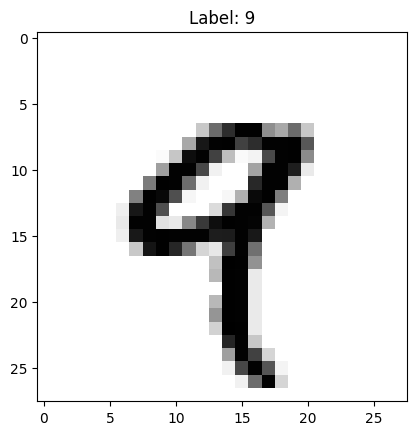

In [63]:
digit = train_images[4]  # 5th image (index 4!)
plt.imshow(digit, cmap=plt.cm.binary)  # plot image
plt.title(f"Label: {train_labels[4]}");  # label for 5th image

It's interesting to notice that these images are actually NumPy arrays:

In [64]:
type(digit)

numpy.ndarray

The images have a size of 28 by 28 pixels:

In [65]:
digit.shape

(28, 28)

They are black and white images, so there is only one channel for the gray scale. RGB images, for instance, have three channels: one for red (R), one for blue (B), and one for green (G). These images would be 3D arrays. The data type of the elements is `uint8`, which stands for unsigned integer of 8 bits:

In [66]:
digit.dtype

dtype('uint8')

Unsigned means that all elements are positive, and 8 bit implies there are $2^8$ or 256 possible values. As 0 is included, the maximum value is 255:

In [67]:
digit.min(), digit.max()

(0, 255)

Each pixel is a feature and so we need to "reshape" the images. In other words, we need to put all the pixels of an image one after the other, so that they form one long row. Then we put the different images below each other and so we get a 'table' with in the rows the examples, here the images, and in the columns the features, here the 28 x 28 = 784 pixels.

In addition, we must normalize the pixel values to floats between 0 and 1. We do that simply by dividing the values by 255:

In [68]:
train_images = train_images.reshape((60000, 28 * 28))  # reshape
train_images = train_images.astype("float32") / 255  # normalize and convert to float
test_images = test_images.reshape((10000, 28 * 28))  # reshape
test_images = test_images.astype("float32") / 255  # normalize and convert to float

### Dense neural network

We will now first build a network consisting of 'classical' `Dense` layers. We instantiate a so-called `Sequential` model that consists of a sequence of layers. We will define 3 layers:

- The *input layer* that accepts the converted images. The input size is thus `(None, 784)`, where the `None` refers to the number of images processed during one iteration of the algorithm. That number is called the *batch size*.
- A *hidden layer* that consists of 512 neurons and applies `"relu"` (rectified linear unit) as the activation function.
- The *output layer* that consists of 10 neurons because we have 10 classes. There are 10 classes because there are 10 digits: from 0 to 9. So each neuron in the output layer corresponds to a digit. The `"softmax"` activation function lets each neuron in the output layer return a probability as output. The neuron with the highest probability indicates the digit that the model predicts.

It's important to realize that we are dealing here with **multi-class classification** instead of binary classification as we have more than 2 classes. So the softmax function could be seen as the generalized form of the sigmoid function for multi-class classification.

In [69]:
model = keras.Sequential([
 keras.layers.Dense(512, activation="relu"),  # hidden layer consisting of 512 neurons and relu as activation
 keras.layers.Dense(10, activation="softmax")  # output layer consisting of 10 neurons and softmax as activation
])

model.build(input_shape=(None, 28 * 28))  # number of neurons for the input layer
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

We see that the model consists of 407,050 parameters! Compare this to single linear regression where the algorithm had to derive only 2 parameters....

Before we can begin training the model, we must first compile it. We need to specify what loss function the algorithm should use, and what optimizer it must apply to minimize that loss function. Explaining what exactly `"sparse_categorical_crossentropy"` means is out of scope, but keep in mind it is used as a loss function for multi-class classification models in which labels are represented as integers, like here.

We will also specify that we want the accuracy to be calculated after each epoch. Of course, we already know the `"accuracy"` metric: it is the number of correctly classified images divided by the total number of images.

And we also know what an *epoch* is. Indeed, the algorithm will repeatedly go through the entire dataset to optimize the parameters. When the algorithm has fully processed the dataset one time, it has completed one epoch.

In [70]:
model.compile(
    loss="sparse_categorical_crossentropy",  # loss function that calculates difference between predicted and true labels
    optimizer="rmsprop",  # algorithm that minimizes the loss function
    metrics=["accuracy"]  # calculate accuracy after each iteration (epoch)
  )

Voila, we are ready to train the model. Just like with Scikit-Learn, with Keras we also call the method `fit`, and we pass the features and labels to it: `train_images` and `train_labels`. So we use only the training set! We also need to specify the number of epochs and the batch size. In this case, 5 epochs will suffice and we let the algorithm process 128 images at once.

In [71]:
model.fit(train_images, train_labels, epochs=5, batch_size=128);  # training the model using the training set

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8741 - loss: 0.4423
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9657 - loss: 0.1167
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9791 - loss: 0.0697
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9860 - loss: 0.0488
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9896 - loss: 0.0364


The model achieves a very high accuracy of almost 99%! But does it perform as well on the test set?

In [72]:
test_loss, test_acc = model.evaluate(test_images, test_labels)  # evaluate model using the test set
print(f"accuracy on the test set: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9783 - loss: 0.0723
accuracy on the test set: 0.9818999767303467


The accuracy on the test is also very high! So that looks good!

Should the accuracy of the test set be much lower, our model would suffer from **overfitting**. As we already know, we basically need to use a third set to detect overfitting: the validation set. In that case, the loss (and accuracy) is calculated during training for both the validation set and the training set after each epoch. From the moment the loss of the training set keeps decreasing, while that of the validation set does not or even starts to increase, we need to stop. For this example, we figured out in advance that we should stop after about 5 epochs, and therefore, we did not validate the model.

Since overfitting is a fundamental problem in machine learning and deep learning, several regularization techniques are available to avoid it, like using `Dropout` layers.

### Convolutional neural network

In theory, a convnet or CNN performs even better than a `classical` network with dense layers. Let's check that out using the following model that consists of 3 `Conv2D` layers, each separated by a `MaxPooling2D` layer. The first layers apply the convolutional "filters", the second perform some kind of compression. Discussing in detail how these layers work is out of scope.

Unlike the previous model, we don't have to reshape the input images into a long row of pixels. No, because we are applying these "filters", the images should remain rectangular. Hence, the input shape of the input layer is 28 by 28. The number of color channels is also taken into account, but since we are dealing with black and white images, that number is 1.

The output layer is the same as the one in our previous model: a `Dense` layer with 10 neurons, and the softmax function that will give probabilities as output. The `Flatten` layer that comes just before the output layer has the sole function of converting the `rectangular` output of the last convolutional layer to 1 long row, which can be passed to the last `Dense` output layer.

In [73]:
model = keras.Sequential([
  keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation="softmax")  # output layer consisting of 10 neurons and softmax as activation
])

model.build(input_shape=(None, 28, 28, 1))  # input consists of images of 28 x 28 pixels en 1 color channel
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │          11,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,202 (407.04 KB)

 Trainable params: 104,202 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

Now we compile the model in the same way as the previous model:

In [74]:
model.compile(
    loss="sparse_categorical_crossentropy",  # loss function
    optimizer="rmsprop",  # optimizer
    metrics=["accuracy"]  # accuracy as metric
  )

Before we can start training the model, we must "reshape" the training and test set to shape `(60000, 28, 28, 1)` and `(10000, 28, 28, 1)`, respectively:

In [75]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

We are ready now to train the model. Again, we take 5 epochs, and this time, set the batch size to 64:

In [76]:
model.fit(train_images, train_labels, epochs=5, batch_size=64);

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8870 - loss: 0.3564
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9849 - loss: 0.0468
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9900 - loss: 0.0309
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9928 - loss: 0.0227
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9946 - loss: 0.0164


We already achieved a very high accuracy using the previous neural network, but the convnet performs even slightly better!

And what is its accuracy on the test set?

In [77]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"accuracy on the test set: {test_acc}")

accuracy on the test set: 0.9916999936103821


That accuracy is also slightly better!

Let's pick one random image from the test set and predict its label:

In [78]:
# Choose a random image from the test set
np.random.seed(25)
random_index = np.random.randint(0, len(test_images))
image = test_images[random_index]
label = test_labels[random_index]

# Reshape the image for prediction (if necessary)
image = image.reshape(1, 28, 28, 1)

# Predict the label
predictions = model.predict(image, verbose=0)
print(f"Predicted probabilities:\n {predictions[0]}")
predicted_label = np.argmax(predictions)
print(f"\nPredicted label: {predicted_label}")
probability = predictions[0][predicted_label]
print(f"Probability: {probability}")

Predicted probabilities:
 [1.6741055e-08 3.4388770e-06 3.6622383e-05 9.5877156e-05 1.0231869e-11
 6.1974258e-12 1.3074065e-14 9.9986029e-01 3.4105146e-06 2.1455625e-07]

Predicted label: 7
Probability: 0.9998602867126465


We see that the model predicts a probability for each class. Using the function `argmax`, we select the index of the highest probability, which corresponds to the digit that the class represents. Let's plot the image to check whether it is indeed a 7:

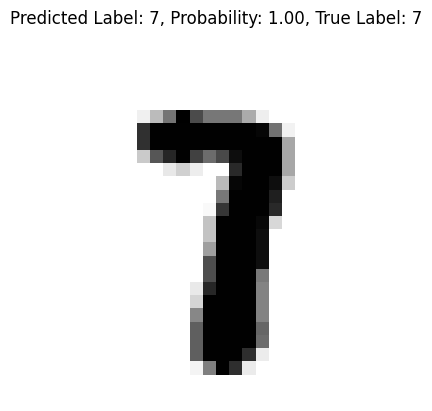

In [79]:
# Plot the image
plt.imshow(image.reshape(28, 28), cmap=plt.cm.binary)
plt.title(f"Predicted Label: {predicted_label}, Probability: {probability:.2f}, True Label: {label}");
plt.gca().axis('off');

A 7 it is indeed! Although the fully connected neural network and the convolutional neural network both do an excellent job here, the convnet performs slightly better. This generally applies to computer vision tasks.

## **6. Pumping Test Interpretation**

Can we also apply neural networks to interpret pumping tests? This is possible if we first train such a network using supervised learning with data that, for example, has been simulated by analytical solutions.

### The pumping test dataset

In this section, we will illustrate this using drawdowns measured during a pumping test conducted in a leaky aquifer. The data are stored in text-file `'./data/pumping_test_data.txt'`:

In [80]:
df = pd.read_csv('./data/pumping_test_data.txt',
                 sep='\t', skiprows=4)  # use tab as separator and skip first 4 rows
df.head()

,time (min),drawdown (m)
0,1,0.050
1,4,0.054
2,7,0.120
3,10,0.175
4,15,0.260


Plotting the data:

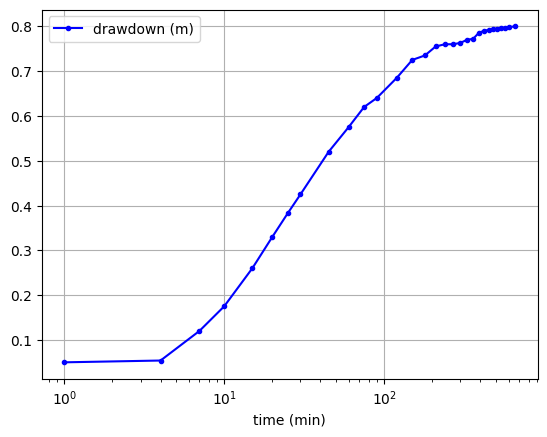

In [81]:
df.plot(x='time (min)', y='drawdown (m)',
        style='b.-', logx=True, grid=True);

The first data point is clearly an outlier; therefore, we'll remove it. The drawdowns were observed during a pumping test conducted in a leaky aquifer consisting of gravel (Jiang Hui et al., 2009). The leakage came from an upper unconfined aquifer, which was separated from the extracted aquifer by an aquitard of silty sand. The fully penetrating pumping well extracted water at a constant rate of 69.1 m³/h. The drawdowns were measured in an observation well at a distance of 197 m from the pumping well.

Optimal values were derived for the aquifer transmissivity and storativity and the resistance of the aquitard by applying the Levenberg-Marquardt algorithm to the Hantush-Jacob solution for well-flow in a leaky aquifer:

- T = 418 m²/d
- S = 0.00014
- c = 804 d

Here, we will only derive a value for the aquifer transmissivity using a neural network. Therefore, the values for S and c are considered known. So, these are the known variables:

In [82]:
Q = 69.1 * 24  # pumping rate in m³/d
r_obs = 197    # observation well distance in m

S = 0.00014    # aquifer storativity (-)
c = 804        # aquitard resistance (d)

t_obs = df['time (min)'].values / 60 / 24  # observation times in days
s_obs = df['drawdown (m)'].values          # observed drawdowns in m
t_obs, s_obs = t_obs[1:], s_obs[1:]        # remove first data point

### Training a neural network

Next, we are going to simulate one thousand synthetic pumping tests using these input variables and the `hantush_jacob` function. Since the transmissivity is considered unknown, each pumping test will have a different value for T, ranging from 10 to 10,000 m²/d:

In [83]:
from maxsypy.special import hantush_jacob

T_range = np.logspace(1, 4, 1000);  # range of T values
s_range = np.array([hantush_jacob(r=r_obs, t=t_obs, S=S, Q=Q, c_top=c, T=T).squeeze()
                    for T in T_range])  # observed drawdowns for each T value
s_range[s_range<=0] = 1e-6  # set negative values for drawdown to 1e-6
s_range.shape

(1000, 29)

We shuffle the elements in `T_range`, and accordinly, the entries of `s_range`:

In [84]:
# prompt: Shuffle the rows of s_range and the elements in T_range accordingly. Use numpy functions.
np.random.seed(0)
permutation = np.random.permutation(len(T_range))
s_range = s_range[permutation]
T_range = T_range[permutation]

We normalize both T and s by applying a logarithmic transformation:

In [85]:
# normalize T and s
X = np.log10(s_range[:, :, np.newaxis])
y = np.log10(T_range[:, np.newaxis])

The following code block defines, compiles, and trains a neural network model using Keras to predict a value of T given a series of observed drawdowns s:

First, a sequential model is created with three layers:
1. A 1D convolutional layer `Conv1D` with 4 filters, a kernel size of 2, and ReLU activation.
2. A flattening layer `Flatten` to convert the 2D output of the convolutional layer into a 1D array.
3. A dense layer `Dense` with a single neuron to output the predicted value for T.

The model is compiled with the Adam optimizer, a learning rate of 0.002, mean squared error (`'mse'`) as the loss function, and mean absolute error (`'mae'`) as a metric.

Finally, the model is trained on the input data `X` and target values `y` for 500 epochs with a batch size of 64, and training progress output is suppressed (`verbose=0`):

In [86]:
# Define the model
model = keras.Sequential([
    keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(1)  # Output layer for T
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002),
              loss='mse', metrics=['mae'])

# Train the model
result = model.fit(X, y,
                   epochs=500, batch_size=64, verbose=0)

Let's plot the evolution of MSE and MAE during training:

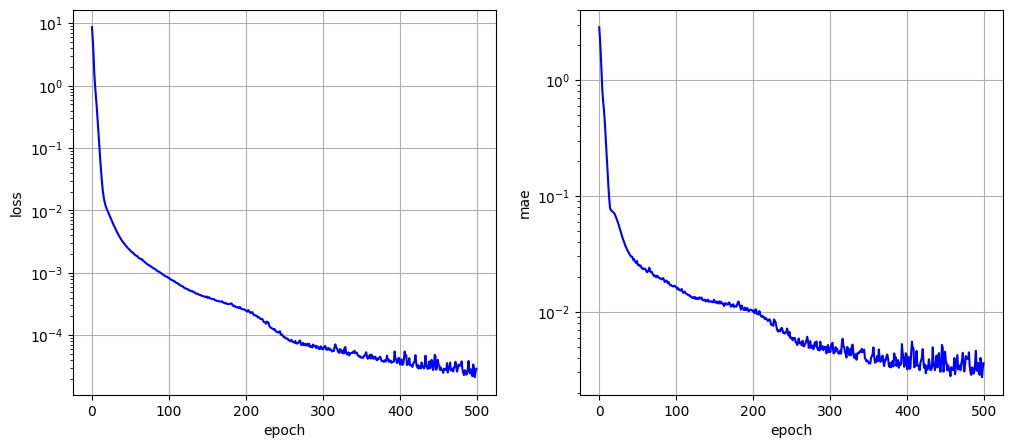

In [87]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, key in zip(axes, ['loss', 'mae']):
    ax.semilogy(result.history[key], 'b-', label='training');
    ax.set_xlabel('epoch');
    ax.set_ylabel(key);
    ax.grid();

The loss is still slightly decreasing after 500 epochs, but the MAE is small enough to stop the training:

In [88]:
mse, mae = model.evaluate(X, y, verbose=0)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

MSE: 2.952805152744986e-05
MAE: 0.003833551425486803


### Predicting the aquifer transmissivity

Calculating the coefficient of determination R² between actual and predicted values of T:

In [89]:
from sklearn.metrics import r2_score

y_pred = model.predict(X, verbose=0)
T_pred = 10**y_pred.squeeze()  # don't forget the target is log10(T)!
print(f'R² = {r2_score(T_range, T_pred)}')

R² = 0.9995040777849719


We obtain an almost perfect fit, as is seen in the plot below:

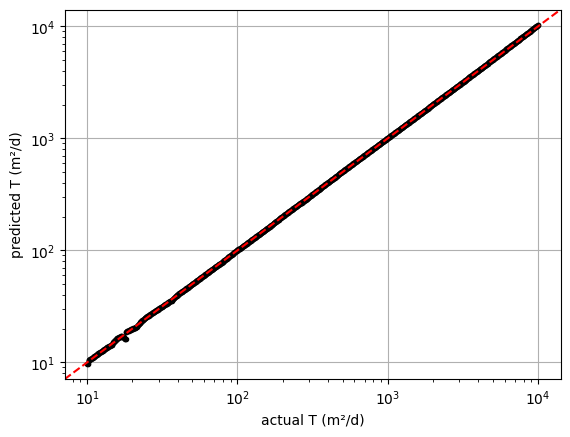

In [90]:
plt.loglog(T_range, T_pred, 'k.');
xl, yl = plt.xlim(), plt.xlim()
plt.loglog(xl, yl, 'r--');
plt.xlim(xl);
plt.ylim(yl);
plt.grid();
plt.xlabel('actual T (m²/d)');
plt.ylabel('predicted T (m²/d)');

Finally, we predict the value for the transmissivity of the leaky aquifer from the drawdowns observed during the actual pumping test, and we plot te result:

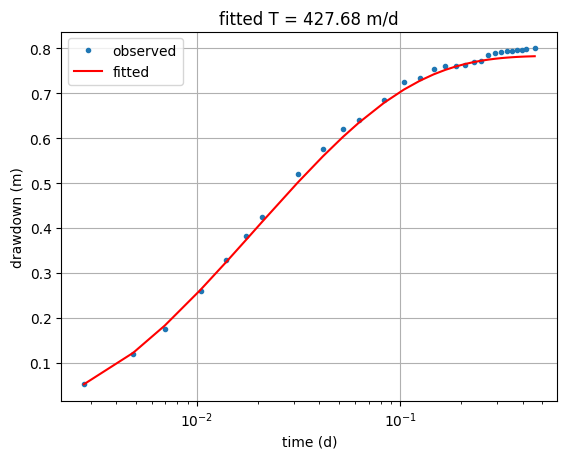

In [91]:
T_fitted = 10**model.predict(np.log10(s_obs[np.newaxis, :, np.newaxis]), verbose=0).squeeze()
s_fitted = hantush_jacob(r=r_obs, t=t_obs, S=S, Q=Q, c_top=c, T=T_fitted).squeeze()

plt.semilogx(t_obs, s_obs, '.', label='observed');
plt.semilogx(t_obs, s_fitted, 'r-', label='fitted');
plt.title(f'fitted T = {T_fitted:.2f} m/d')
plt.xlabel('time (d)');
plt.ylabel('drawdown (m)');
plt.grid();
plt.legend();

The value of 428 m²/d predicted by the neural net is very close to the value of 418 m²/d derived using the Levenberg-Marquardt algorithm, so there is a good match between the fitted curve and the observations. But of course, coupling the Hantush-Jacob solution with the Levenberg-Marquardt algorithm is a more efficient method in this case and also provides a more accurate solution in terms of minimizing the MSE. However, applying a neural network in this way could be advantageous in cases where it is not clear which groundwater flow model should be chosen. In such cases, one can train a neural network with various analytical solutions that might be applicable.

---